In [8]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from anndata import AnnData
import muon as mu
from muon import MuData
from muon import atac as ac

import scanpy as sc
import pybedtools
pybedtools.helpers.set_bedtools_path(
    '/projects/zhanglab/users/ana/bedtools2/bin/')

import time

# inhouse module
import scdrs
import ctar

# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Martin's comments
- Process all datasets in the same format, maybe `h5mu`. Now we only have `neat`. 
- 

### Load data

In [2]:
# Load annotations and references
df_gene = pd.read_csv(
    '/projects/zhanglab/data/gene_annot/gencode_v33/ensg2symbol.txt', sep='\t', header=None,
)
dic_id2sym = {x:y for x,y in zip(df_gene[0], df_gene[1])}

# load crispri flowfish results containing lifted over locations
crispr_file = '/projects/zhanglab/users/ana/multiome/validation/crispr-flowfish-supp5_edited.csv'
crispr_df = pd.read_csv(crispr_file,index_col=0)
print('Positive links: ',crispr_df[crispr_df.Regulated == True].shape[0])
print('Negative links: ',crispr_df[crispr_df.Regulated == False].shape[0])

Positive links:  283
Negative links:  5472


In [3]:
data_path = '/projects/zhanglab/users/ana/multiome/raw'
# Ana: variable names should usually contain 1) data type, 2) dataset info; but here since we are 
# only analyzing one dataset, it is fine to just use "mdata", standard name for mudata
mdata = mu.read(data_path+'/neatseq/neat.h5mu') 
print(mdata['rna'])
print(mdata['atac'])

AnnData object with n_obs × n_vars = 8472 × 36601
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'celltype'
    var: 'chr', 'start', 'end', 'index_x'
AnnData object with n_obs × n_vars = 8472 × 80953
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'celltype'
    var: 'chr', 'start', 'end', 'index_y'


In [37]:
# Raw adata_rna & adata_atac
# Ana: float32 is good for reducing memory cost (to half)
# Ana: I think the filtering steps below are cleaner than your "filter_lowexp" function? 
# Ana: consider incorporate some of the following into a preprocessing function 
adata_rna = mdata.mod['rna'].copy()
adata_rna.X = adata_rna.X.astype(np.float32) # float32 to reduce memory cost
adata_rna.var_names = [dic_id2sym[x] if x in dic_id2sym else x for x in adata_rna.var_names]
adata_atac = mdata.mod['atac'].copy()
adata_atac.X = adata_atac.X.astype(np.float32) # float32 to reduce memory cost
print('Raw, adata_rna', adata_rna.shape, 'adata_atac', adata_atac.shape)

# Filtering & normalization of RNA (using scanpy) (in log scale)
sc.pp.filter_cells(adata_rna, min_genes=250)
sc.pp.filter_genes(adata_rna, min_cells=50)
sc.pp.normalize_per_cell(adata_rna, counts_per_cell_after=1e4)
sc.pp.log1p(adata_rna)
print('Filtering & normalization of RNA', adata_rna.shape)

# Filtering & normalization of ATAC (using mu) (in log scale)
# Following tutorial https://muon-tutorials.readthedocs.io/en/latest/
# single-cell-rna-atac/pbmc10k/2-Chromatin-Accessibility-Processing.html
sc.pp.calculate_qc_metrics(adata_atac, percent_top=None, log1p=False, inplace=True)
mu.pp.filter_var(adata_atac, 'n_cells_by_counts', lambda x: x >= 10)
mu.pp.filter_obs(adata_atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))
mu.pp.filter_obs(adata_atac, 'total_counts', lambda x: (x >= 4000) & (x <= 40000))
sc.pp.normalize_per_cell(adata_atac, counts_per_cell_after=1e4)
sc.pp.log1p(adata_atac)
print('Filtering & normalization of ATAC', adata_atac.shape)

# Align cells
cell_list = [x for x in adata_rna.obs_names if x in set(adata_atac.obs_names)]
adata_rna = adata_rna[cell_list, :].copy()
adata_atac = adata_atac[cell_list, :].copy()
print('Align cells, adata_rna', adata_rna.shape, 'adata_atac', adata_atac.shape)

Raw, adata_rna (8472, 36601) adata_atac (8472, 80953)


/home/martinzh/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Filtering & normalization of RNA (8472, 10912)
Filtering & normalization of ATAC (7389, 80650)
Align cells, adata_rna (7389, 10912) adata_atac (7389, 80650)


/home/martinzh/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/martinzh/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/martinzh/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ig

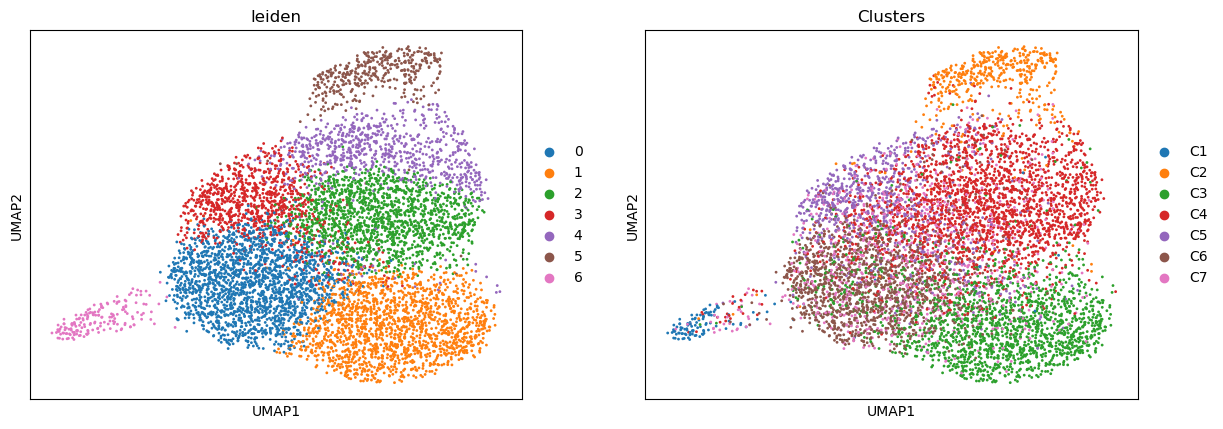

In [38]:
# UMAP and clustering for data exploration
# Ana: UMAP is usually very informative of the overall data distribution 
# The following is a standard set of code for clustering and umap
sc.pp.highly_variable_genes(adata_rna, subset = False, min_disp=.5, 
                            min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None)
sc.pp.scale(adata_rna, max_value=10, zero_center=False)
sc.pp.pca(adata_rna, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_rna, n_neighbors=50, n_pcs=20, use_rep="X_pca")
sc.tl.leiden(adata_rna, resolution=0.7)   
sc.tl.umap(adata_rna)
sc.pl.umap(adata_rna, color=['leiden', 'Clusters'])
adata_atac.obsm = adata_rna.obsm.copy()

### Analysis: assemble a set of truth

In [6]:
# Align GT and data for genes and peaks 
# Get a list of postive controls and a list of negative controls 
df_gt = crispr_df.copy()
df_gt['chr'] = crispr_df['hg38_chr']
df_gt['start'] = crispr_df['hg38_start']
df_gt['end'] = crispr_df['hg38_end']
df_gt['gene'] = crispr_df['GeneSymbol']
df_gt['peak'] = ['%s:%d-%d'%(x,y,z) for x,y,z in zip(df_gt['chr'], df_gt['start'], df_gt['end'])]

# NEAT coordinates are in hg38
df_peak = adata_atac.var.copy() # 
df_peak['peak'] = df_peak.index
df_peak = df_peak.loc[df_peak['mean_counts']>0.01].copy() # filter by mean_counts
df_peak.index.name = ''
df_gene = adata_rna.var.copy() # 
df_gene['gene'] = df_gene.index
df_gene.index.name = ''

# Restrict to GT genes to reduce computation
print('GT n_gene=%d, n_peak=%d, n_link=%d' % 
      (len(set(df_gt['gene'])), len(set(df_gt['peak'])), df_gt.shape[0]))
gene_list = [x for x in df_gene['gene'] if x in set(df_gt['gene'])]
df_gt = df_gt.loc[df_gt['gene'].isin(gene_list)].copy()
df_gene = df_gene.loc[gene_list].copy()
df_link = ctar.data_loader.peak_to_gene(df_peak, df_gene)
df_link = df_link.merge(df_peak[['chr', 'start', 'end', 'peak']], on=['peak'])
print('df_link', df_link.shape)

# Intersect w/ truth 
link_bed = pybedtools.BedTool.from_dataframe(df_link[['chr', 'start', 'end', 'gene']])
gt_pos_bed = pybedtools.BedTool.from_dataframe(df_gt[df_gt['Regulated']][['chr', 'start', 'end', 'gene']])
gt_neg_bed = pybedtools.BedTool.from_dataframe(df_gt[~df_gt['Regulated']][['chr', 'start', 'end', 'gene']])
temp_col_list = ['chr', 'start', 'end', 'gene', 'gt_chr', 'gt_start', 'gt_end', 'gt_gene']

temp_bed = link_bed.intersect(gt_pos_bed, wa=True, wb=True)
df_pos = temp_bed.to_dataframe(index_col=False, names=temp_col_list)
df_pos = df_pos.loc[df_pos['gene']==df_pos['gt_gene']].copy()
df_pos['peak'] = ['%s:%d-%d'%(x,y,z) for x,y,z in zip(df_pos['chr'], df_pos['start'], df_pos['end'])]
df_pos['gt_peak'] = ['%s:%d-%d'%(x,y,z) for x,y,z in zip(df_pos['gt_chr'], df_pos['gt_start'], df_pos['gt_end'])]
df_pos['label'] = True

temp_bed = link_bed.intersect(gt_neg_bed, wa=True, wb=True)
df_neg = temp_bed.to_dataframe(index_col=False, names=temp_col_list)
df_neg = df_neg.loc[df_neg['gene']==df_neg['gt_gene']].copy()
df_neg['peak'] = ['%s:%d-%d'%(x,y,z) for x,y,z in zip(df_neg['chr'], df_neg['start'], df_neg['end'])]
df_neg['gt_peak'] = ['%s:%d-%d'%(x,y,z) for x,y,z in zip(df_neg['gt_chr'], df_neg['gt_start'], df_neg['gt_end'])]
df_neg['label'] = False

df_gt_align = pd.concat([df_pos, df_neg], axis=0)
df_gt_align.sort_values(by=['chr', 'gt_start'], inplace=True)
df_gt_align.index = ['%s;%s'%(x,y) for x,y in zip(df_gt_align['gene'], df_gt_align['peak'])]

print('n_pos=%d, n_neg=%d' % (df_gt_align['label'].sum(), (~df_gt_align['label']).sum()))
display(df_gt_align.iloc[:5])

# load scent results
scent_file = '/projects/zhanglab/users/ana/multiome/results/scent/paper_results'\
    '/NEAT_allqced_bootpkg_nopc_allCT.FDR0.10.txt.gz'
scent_df = pd.read_csv(scent_file, sep='\t')
# parse regions
scent_df[['chr', 'start', 'end']] = scent_df['peak'].str.split('-',expand=True)
scent_df['peak'] = ['%s:%s-%s'%(x,y,z) for x,y,z in zip(scent_df['chr'], scent_df['start'], scent_df['end'])]
scent_df.index = ['%s;%s'%(x,y) for x,y in zip(scent_df['gene'], scent_df['peak'])]
gt_scent_list = list(set(df_gt_align.index) & set(scent_df.index))
display(df_gt_align.loc[gt_scent_list])


GT n_gene=113, n_peak=1933, n_link=5755
df_link (5019, 6)
n_pos=123, n_neg=1575


,chr,start,end,gene,gt_chr,gt_start,gt_end,gt_gene,peak,gt_peak,label
EPB41;chr1:28884927-28885427,chr1,28884927,28885427,EPB41,chr1,28885079,28885118,EPB41,chr1:28884927-28885427,chr1:28885079-28885118,True
IL2RA;chr10:5684442-5684942,chr10,5684442,5684942,IL2RA,chr10,5684468,5685204,IL2RA,chr10:5684442-5684942,chr10:5684468-5685204,False
IL2RA;chr10:5685129-5685629,chr10,5685129,5685629,IL2RA,chr10,5684468,5685204,IL2RA,chr10:5685129-5685629,chr10:5684468-5685204,False
IL2RA;chr10:5813270-5813770,chr10,5813270,5813770,IL2RA,chr10,5813265,5813799,IL2RA,chr10:5813270-5813770,chr10:5813265-5813799,False
IL2RA;chr10:6050961-6051461,chr10,6050961,6051461,IL2RA,chr10,6050939,6051439,IL2RA,chr10:6050961-6051461,chr10:6050939-6051439,False


,chr,start,end,gene,gt_chr,gt_start,gt_end,gt_gene,peak,gt_peak,label
JUNB;chr19:12775397-12775897,chr19,12775397,12775897,JUNB,chr19,12775370,12776011,JUNB,chr19:12775397-12775897,chr19:12775370-12776011,False
JUNB;chr19:12782091-12782591,chr19,12782091,12782591,JUNB,chr19,12782291,12783171,JUNB,chr19:12782091-12782591,chr19:12782291-12783171,True
PFKFB3;chr10:6347944-6348444,chr10,6347944,6348444,PFKFB3,chr10,6348010,6348510,PFKFB3,chr10:6347944-6348444,chr10:6348010-6348510,True
PFKFB3;chr10:6347944-6348444,chr10,6347944,6348444,PFKFB3,chr10,6348024,6348524,PFKFB3,chr10:6347944-6348444,chr10:6348024-6348524,False
JUNB;chr19:12789795-12790295,chr19,12789795,12790295,JUNB,chr19,12789831,12790351,JUNB,chr19:12789795-12790295,chr19:12789831-12790351,True


### Analysis: on high-confidence examples

JUNB;chr19:12775397-12775897 False


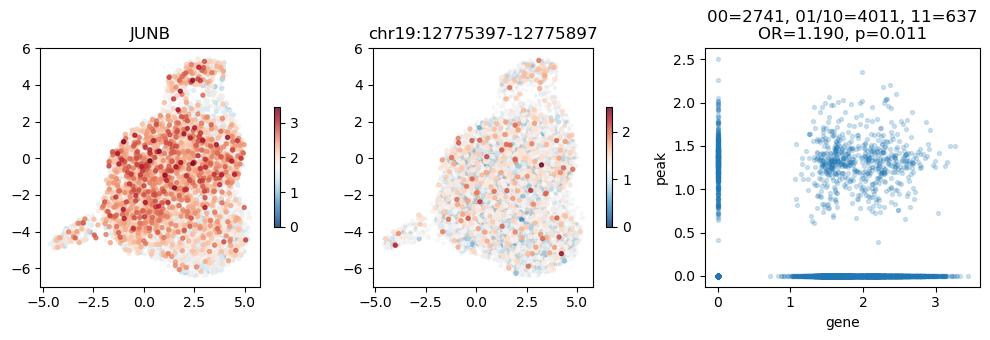

JUNB;chr19:12782091-12782591 True


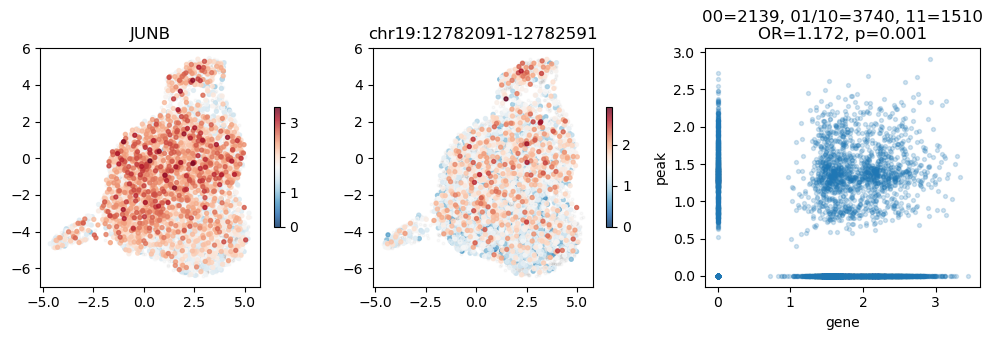

PFKFB3;chr10:6347944-6348444 PFKFB3;chr10:6347944-6348444     True
PFKFB3;chr10:6347944-6348444    False
Name: label, dtype: bool


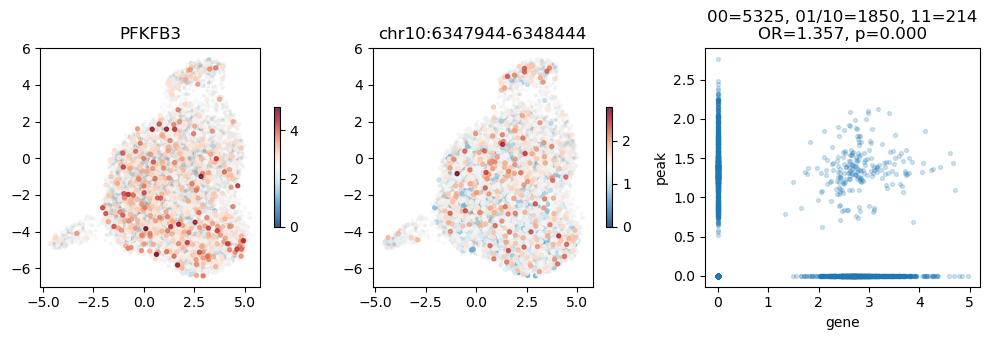

JUNB;chr19:12789795-12790295 True


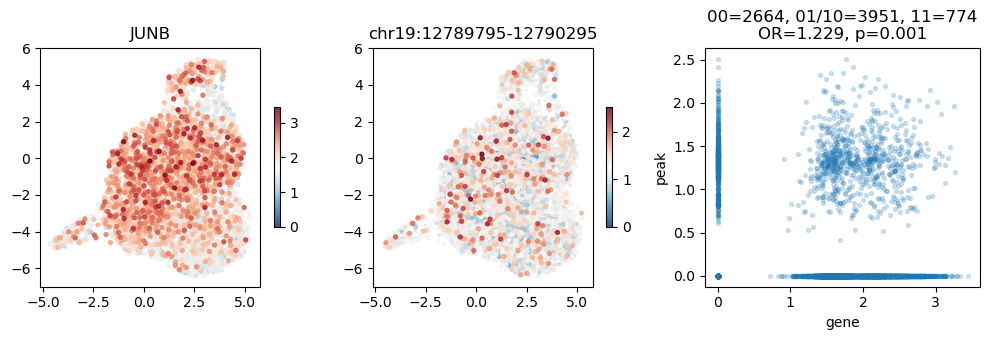

In [77]:
# Let's do some really cool UMAP visualizations to understand the data
df_umap = pd.DataFrame(index=adata_rna.obs_names, columns=['UMAP1', 'UMAP2'], data=adata_rna.obsm['X_umap'])
for link in gt_scent_list:
    gene,peak = link.split(';')
    df_plot = df_umap.copy()
    df_plot['gene'] = adata_rna[:, gene].X.toarray().flatten()
    df_plot['peak'] = adata_atac[:, peak].X.toarray().flatten()

    print(link, df_gt_align.loc[link, 'label'])
    
    plt.figure(figsize=[10,3.5])
    ax = plt.subplot(1,3,1)
    ind_select = df_plot['gene']>0
    df_plot.sort_values('gene', ascending=True, inplace=True)
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', s=4, alpha=0.025)
    plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                c=df_plot.loc[ind_select, 'gene'], cmap='RdBu_r', s=8, vmin=0, alpha=0.8)
    plt.colorbar(shrink=0.5)
    plt.title('%s'%gene)
    
    ax = plt.subplot(1,3,2)
    ind_select = df_plot['peak']>0
    df_plot.sort_values('peak', ascending=True, inplace=True)
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', s=4, alpha=0.025)
    plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                c=df_plot.loc[ind_select, 'peak'],
                cmap='RdBu_r', s=8, vmin=0, alpha=0.8)
    plt.colorbar(shrink=0.5)
    plt.title('%s'%peak)
    
    ax = plt.subplot(1,3,3)
    plt.scatter(df_plot['gene'], df_plot['peak'], s=8, alpha=0.2)
    plt.xlabel('gene')
    plt.ylabel('peak')
    n_11 = ((df_plot['gene']>0)&(df_plot['peak']>0)).sum()
    n_01 = ((df_plot['gene']==0)&(df_plot['peak']>0)).sum()
    n_10 = ((df_plot['gene']>0)&(df_plot['peak']==0)).sum()
    n_00 = ((df_plot['gene']==0)&(df_plot['peak']==0)).sum()
    
    oddsratio, pvalue = sp.stats.fisher_exact([[n_11, n_01], [n_10, n_00]])
    plt.title('00=%d, 01/10=%d, 11=%d\nOR=%0.3f, p=%.3f' % (n_00, n_10+n_01, n_11, oddsratio, pvalue))

    plt.tight_layout()
    plt.show()
    
#     break

/home/martinzh/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/martinzh/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/martinzh/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values

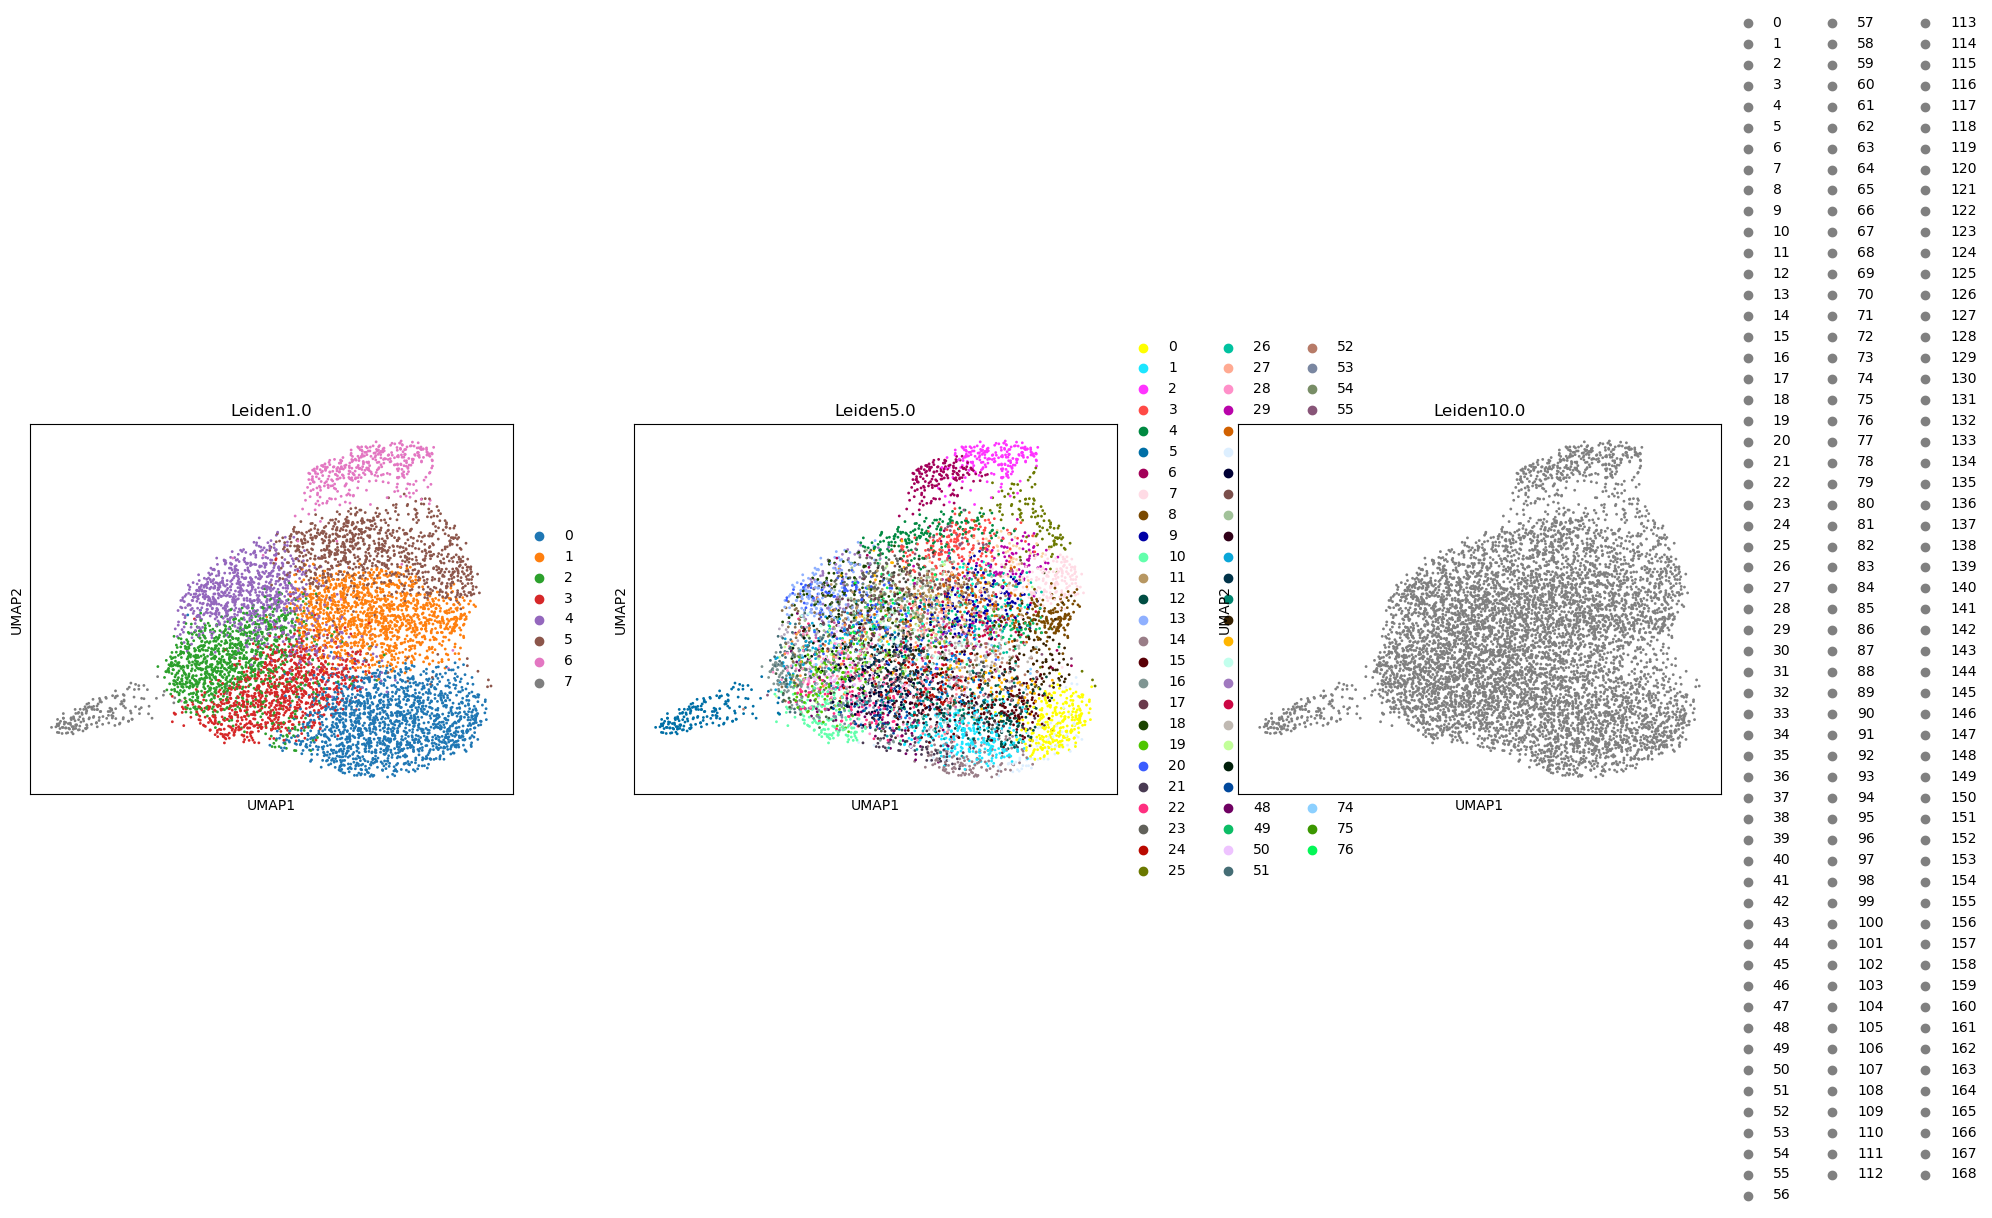

In [40]:
res_list = [1, 5, 10]
for res in res_list:
    sc.tl.leiden(adata_rna, resolution=res, key_added='Leiden%.1f'%res)   
sc.pl.umap(adata_rna, color=[x for x in adata_rna.obs if x.startswith('Leiden')])

In [107]:
for link in gt_scent_list:
    gene,peak = link.split(';')
    print(link, df_gt_align.loc[link, 'label'])
    v_rna = adata_rna[:, gene].X.toarray().flatten()
    v_atac = adata_atac[:, peak].X.toarray().flatten()
    
    df_stats = adata_rna.obs[['Leiden%.1f'%x for x in res_list]].copy()
    df_stats['gene'] = v_rna
    df_stats['peak'] = v_atac
    
    for res in res_list:
        temp_df = df_stats.groupby('Leiden%.1f'%res, observed=True).agg({'gene':'mean', 'peak':'mean'})
        cor,p = sp.stats.pearsonr(temp_df['gene'], temp_df['peak'])
        print('res=%0.1f, cor=%0.3f' % (res, cor))
        
    # cross greary-c
#     C = ctar.mz.gearys_c(adata_rna, v_rna)
    C = ctar.mz.gearys_c_pw(adata_rna, v_rna, v_atac)
    print('C=%0.3f' % C)
    
    print('')

JUNB;chr19:12775397-12775897 False
res=1.0, cor=0.600
res=5.0, cor=0.275
res=10.0, cor=0.178
1130744239.5820594 518262648.61225224
C=2.182

JUNB;chr19:12782091-12782591 True
res=1.0, cor=0.797
res=5.0, cor=0.507
res=10.0, cor=0.358
1008303740.9714841 767867411.5810689
C=1.313

PFKFB3;chr10:6347944-6348444 PFKFB3;chr10:6347944-6348444     True
PFKFB3;chr10:6347944-6348444    False
Name: label, dtype: bool
res=1.0, cor=0.455
res=5.0, cor=0.292
res=10.0, cor=0.259
712080325.8312328 589578599.0471263
C=1.208

JUNB;chr19:12789795-12790295 True
res=1.0, cor=0.051
res=5.0, cor=0.242
res=10.0, cor=0.070
1114352077.8598104 571793353.5010128
C=1.949



### Analysis: systematic benchmark on GT links

In [120]:
df_res = df_gt_align.copy()
df_res.index = ['%s;%s'%(x,y) for x,y in zip(df_res['gene'], df_res['peak'])]
dic_res = {
    'pearsonr' : [], 'pearsonr_p' : [], 
    'spearmanr' : [], 'spearmanr_p' : [], 
    'or' : [], 'or_p':[],
    'C' : []
}
dic_res.update({'C%0.1f'%x:[] for x in res_list})
# pearson
start_time = time.time()
for term in df_res.index:
    gene,peak = term.split(';')
    v_rna = adata_rna[:, gene].X.toarray().flatten()
    v_atac = adata_atac[:, peak].X.toarray().flatten()
    # pearsonr
    cor,p = sp.stats.pearsonr(v_rna, v_atac)
    dic_res['pearsonr'].append(cor)
    dic_res['pearsonr_p'].append(p)
    # spearmanr
    cor,p = sp.stats.spearmanr(v_rna, v_atac)
    dic_res['spearmanr'].append(cor)   
    dic_res['spearmanr_p'].append(p)   
    # OR 
    n_11 = ((v_rna>0)&(v_atac>0)).sum()
    n_01 = ((v_rna==0)&(v_atac>0)).sum()
    n_10 = ((v_rna>0)&(v_atac==0)).sum()
    n_00 = ((v_rna==0)&(v_atac==0)).sum()
    oddsratio, pvalue = sp.stats.fisher_exact([[n_11, n_01], [n_10, n_00]])
    dic_res['or'].append(oddsratio) 
    dic_res['or_p'].append(1-pvalue) 
    # C
    temp_v1 = (v_rna - np.mean(v_rna)) / np.std(v_rna)
    temp_v2 = (v_atac - np.mean(v_atac)) / np.std(v_atac)
    C = ctar.mz.gearys_c_pw(adata_rna, temp_v1, temp_v2)
    dic_res['C'].append(-C) 
    # cluster-level psuedobulk average
    df_stats = adata_rna.obs[['Leiden%.1f'%x for x in res_list]].copy()
    df_stats['gene'] = v_rna
    df_stats['peak'] = v_atac
    for res in res_list:
        temp_df = df_stats.groupby('Leiden%.1f'%res, observed=True).agg({'gene':'mean', 'peak':'mean'})
        cor,p = sp.stats.pearsonr(temp_df['gene'], temp_df['peak'])
        dic_res['C%.1f'%res].append(1-p)
    
for term in dic_res:
    df_res[term] = dic_res[term]
print('time=%0.2fs' % (time.time() - start_time))

time=84.13s


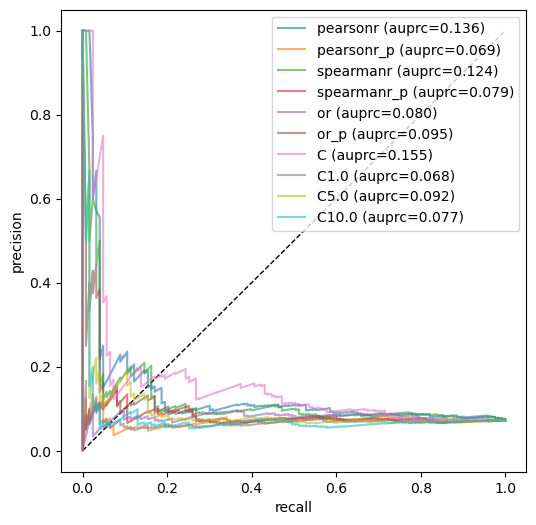

In [123]:
from sklearn import metrics
y_true = df_res['label']

plt.figure(figsize=[6,6])
for method in dic_res:
# for method in ['pearsonr', 'C', 'C5.0']:
    y_scores = df_res[method]
    precision, recall, thresholds  = metrics.precision_recall_curve(y_true, y_scores, pos_label=True)
    auprc = metrics.auc(recall, precision)
    plt.plot(recall, precision, '-', alpha=0.6, label = '%s (auprc=%.3f)'%(method, auprc))
plt.plot([0,1], [0, 1], '--', linewidth=1, zorder=0, color='k')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(loc='upper right')
plt.show()

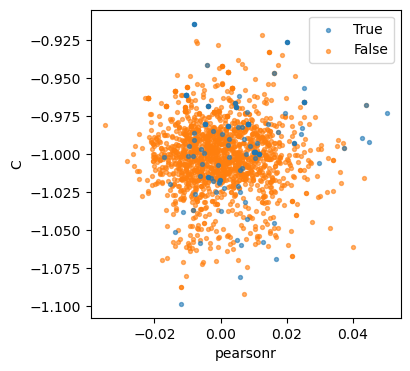

In [125]:
plt.figure(figsize=[4,4])
md1 = 'pearsonr'
# md2 = 'C5.0'
md2 = 'C'

plt.scatter(
    df_res.loc[df_res['label'], md1], df_res.loc[df_res['label'], md2], label='True',
    s=8, alpha=0.6, zorder=10,
)
plt.scatter(
    df_res.loc[~df_res['label'], md1], df_res.loc[~df_res['label'], md2], label='False',
    s=8, alpha=0.6
)
plt.xlabel(md1)
plt.ylabel(md2)
plt.legend()
plt.show()

### Old code

In [121]:
df_res = df_gt_align.copy()
df_res.index = ['%s;%s'%(x,y) for x,y in zip(df_res['gene'], df_res['peak'])]
df_res['pearsonr'] = 0
df_res['spearmanr'] = 0

for term in df_res.index:
    gene,peak = term.split(';')
    cor,p = sp.stats.pearsonr(
        adata_rna[:, gene].X.toarray().flatten(), adata_atac[:, peak].X.toarray().flatten()
    )
    df_res.loc[term, 'pearsonr'] = cor
    cor,p = sp.stats.spearmanr(
        adata_rna[:, gene].X.toarray().flatten(), adata_atac[:, peak].X.toarray().flatten()
    )
    df_res.loc[term, 'spearmanr'] = cor

/tmp/ipykernel_18567/366037699.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0024095908656434667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_res.loc[term, 'pearsonr'] = cor
/tmp/ipykernel_18567/366037699.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0004990742366664476' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_res.loc[term, 'spearmanr'] = cor


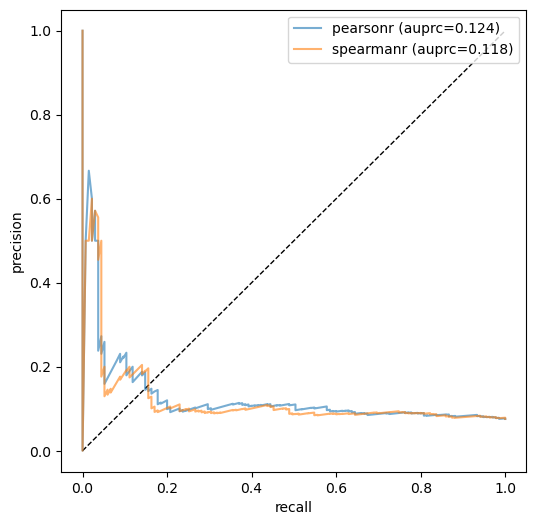

In [147]:
from sklearn import metrics
import matplotlib.pyplot as plt
y_true = df_res['label']

plt.figure(figsize=[6,6])

for method in ['pearsonr', 'spearmanr']:
    y_scores = df_res[method]
    precision, recall, thresholds  = metrics.precision_recall_curve(y_true, y_scores, pos_label=True)
    auprc = metrics.auc(recall, precision)
    plt.plot(recall, precision, '-', alpha=0.6, label = '%s (auprc=%.3f)'%(method, auprc))
plt.plot([0,1], [0, 1], '--', linewidth=1, zorder=0, color='k')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(loc='upper right')
plt.show()

In [141]:
precision.shape

(1563,)

/home/martinzh/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/martinzh/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/martinzh/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/martinzh/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

<Axes: xlabel='pearsonr', ylabel='Count'>

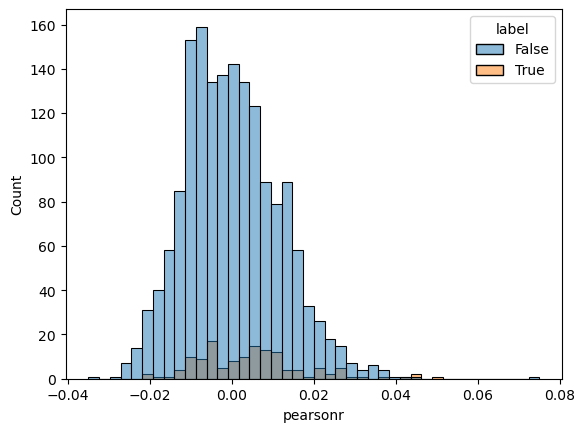

In [123]:
import seaborn as sns
sns.histplot(df_res, x='pearsonr', hue='label')

/home/martinzh/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/martinzh/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/martinzh/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/martinzh/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

<Axes: xlabel='spearmanr', ylabel='Count'>

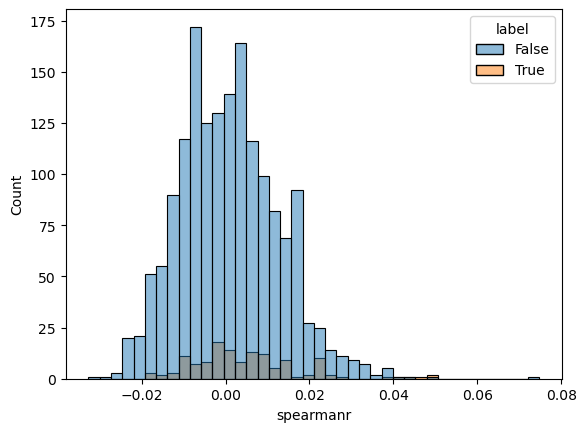

In [124]:
sns.histplot(df_res, x='spearmanr', hue='label')

### Analysis (Ana)
comments
- `filter_vars` reduce the number of pairs from 1811202 to 66010. It is a bit aggresive
- `build_adata` takes a lot of memory and is slow. It is best to keep separate `rna` and `atac` matrics, and fetch the relevant columns when doing the computation. In this way, you can reduce the number of features from `n_pair` to `n_gene+n_peak`
- Poission regression seems to be fine

In [ ]:
# # gets gene body coords and adds +/-500kb windows
# genes = ctar.data_loader.get_gene_coords(neat_mu['rna'].var)
# # adjust peak to bed format
# peaks = neat_mu['atac'].var.copy()
# peaks[['chr','start','end']] = peaks.peak.str.split(':|-',expand=True)
# # gets intersection of peaks and +/-500kb windows around genes
# peak_gene_pairs = ctar.data_loader.peak_to_gene(peaks,genes)
# # add this to mu_neat.uns
# neat_mu.uns['peak_gene_pairs'] = peak_gene_pairs
# # note: takes around 1-2min.

In [8]:
start_time = time.time()
neat = ctar.data_loader.build_adata(neat_mu,gene_col='gene',peak_col='peak',raw=True)
print(neat.shape)
# filter out lowly expressed peaks or genes with < 5% cells expressing.
neat,lowexp_mask = ctar.method.filter_vars(neat)
print('After filtering', neat.shape)
print('Time=%0.1fs' % (time.time()-start_time))

Time=26.5s


In [10]:
start_time = time.time()
neat = ctar.method.get_poiss_coeff(neat)
print('Time=%0.1fs' % (time.time()-start_time))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66010/66010 [09:17<00:00, 118.35it/s]


Time=568.0s


### Analysis (Martin)

In [44]:
adata_gene = neat_mu['rna'].copy()
adata_gene.X = adata_gene.X.astype(np.float32) # float32 to reduce memory cost
adata_gene.var_names = [dic_id2sym[x] if x in dic_id2sym else x for x in adata_gene.var_names]
adata_peak = neat_mu['atac'].copy()
adata_peak.X = adata_peak.X.astype(np.float32) # float32 to reduce memory cost

Before filtering (8472, 36601)
After filtering (8472, 10912)


/home/martinzh/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/martinzh/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/martinzh/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ig

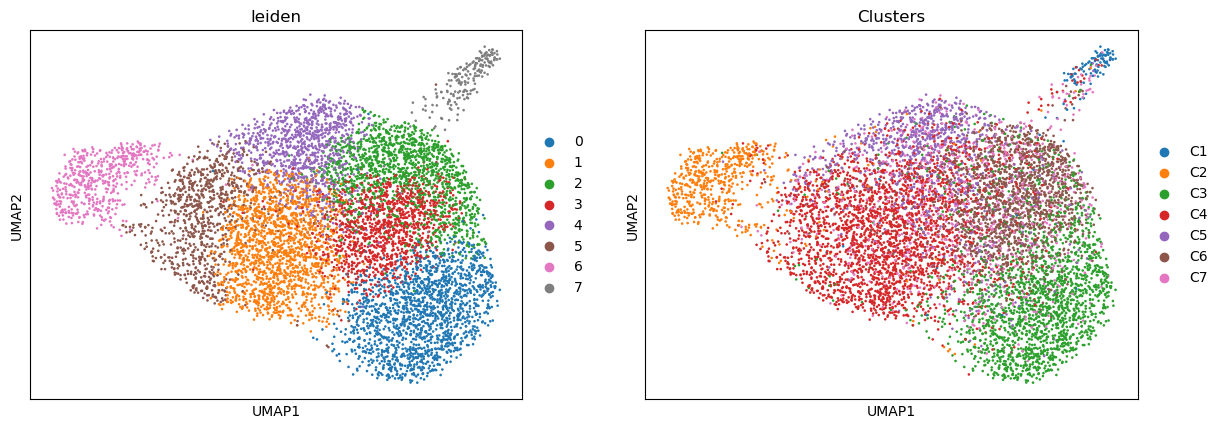

In [52]:
# UMAP and clustering for data exploration
print('Before filtering', adata_gene.shape)
sc.pp.filter_cells(adata_gene, min_genes=250)
sc.pp.filter_genes(adata_gene, min_cells=50)
sc.pp.normalize_per_cell(adata_gene, counts_per_cell_after=1e4)
sc.pp.log1p(adata_gene)
print('After filtering', adata_gene.shape)
sc.pp.highly_variable_genes(adata_gene, subset = False, min_disp=.5, 
                            min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None)
sc.pp.scale(adata_gene, max_value=10, zero_center=False)
sc.pp.pca(adata_gene, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_gene, n_neighbors=50, n_pcs=20, use_rep="X_pca")
sc.tl.leiden(adata_gene, resolution=0.7)   
sc.tl.umap(adata_gene)
sc.pl.umap(adata_gene, color=['leiden', 'Clusters'])
adata_peak.uns = adata_gene.uns.copy()

In [59]:
# load scent results
scent_file = '/projects/zhanglab/users/ana/multiome/results/scent/paper_results/NEAT_allqced_bootpkg_nopc_allCT.FDR0.10.txt.gz'
scent_df = pd.read_csv(scent_file, sep='\t')
# parse regions
scent_df[['CHROM', 'START', 'END']] = scent_df['peak'].str.split('-',expand=True)
scent_df.dropna(subset=['CHROM', 'START', 'END'], inplace=True)

# convert to bed
scent_bed = pybedtools.BedTool.from_dataframe(scent_df[['CHROM', 'START', 'END', 'gene']])

In [56]:
# Pick a few examples
# convert to bed
columns = ['hg38_chr','hg38_start','hg38_end','GeneSymbol']
crispr_pos_bed = pybedtools.BedTool.from_dataframe(crispr_df[crispr_df.Regulated == True][columns])
crispr_neg_bed = pybedtools.BedTool.from_dataframe(crispr_df[crispr_df.Regulated == False][columns])

In [60]:
positive_links = scent_bed.intersect(crispr_pos_bed, wa=True, wb=True)
positive_links = positive_links.to_dataframe(
    index_col=False,names=['CHROM', 'START', 'END', 'GENE', 'CF_CHROM', 'CF_START', 'CF_END', 'CF_GENE']
)
positive_links[positive_links.GENE == positive_links.CF_GENE].shape

(3, 8)

In [61]:
negative_links = scent_bed.intersect(crispr_neg_bed, wa=True, wb=True)
negative_links = negative_links.to_dataframe(index_col=False,names=['CHROM', 'START', 'END', 'GENE', 'CF_CHROM', 'CF_START', 'CF_END', 'CF_GENE'])
negative_links[negative_links.GENE == negative_links.CF_GENE].shape

(2, 8)

In [96]:
adata_gene.obsm

AxisArrays with keys: X_pca, X_umap

In [97]:
adata_peak.obsm = adata_gene.obsm

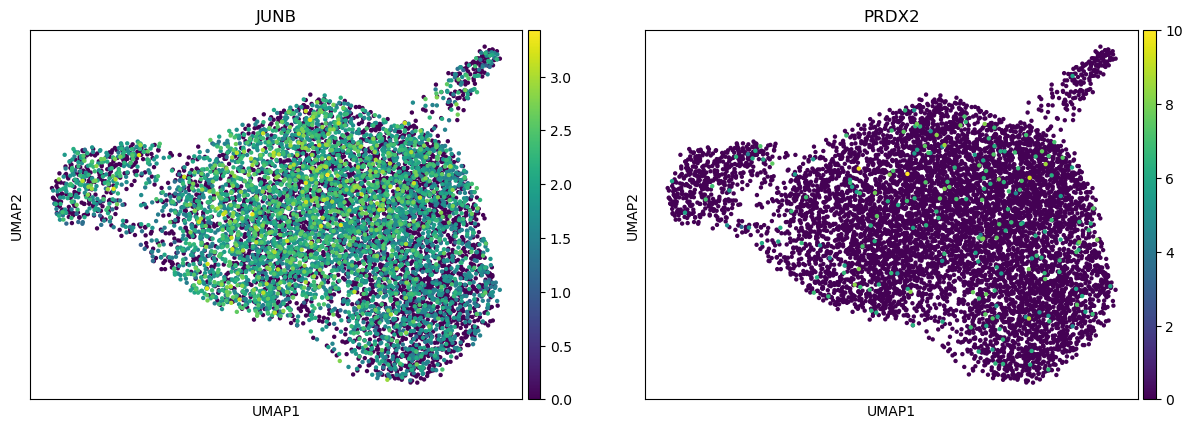

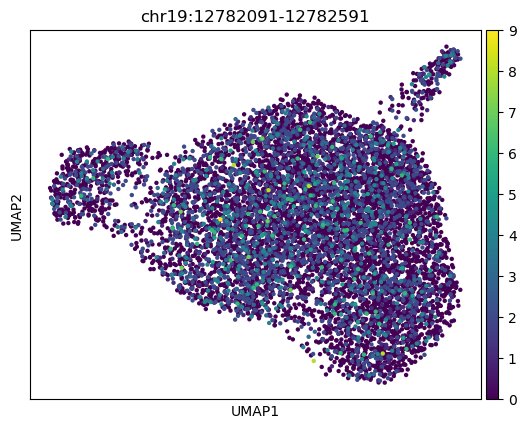

In [100]:
sc.pl.umap(adata_gene, color=['JUNB', 'PRDX2'], s=40)
sc.pl.umap(adata_peak, color=['chr19:12782091-12782591'], s=40)

In [ ]:
sc.pl.umap(adata_peak, color=['JUNB', 'PRDX2'])

In [94]:
adata_peak.var_names[
    (adata_peak.var['chr']=='chr19') & 
    (adata_peak.var['start'].astype(int)<12782591) & 
    (adata_peak.var['end'].astype(int)>12782091) 
]

Index(['chr19:12782091-12782591'], dtype='object', name='peak')

In [83]:
positive_links

,CHROM,START,END,GENE,CF_CHROM,CF_START,CF_END,CF_GENE
0,chr19,12782091,12782591,HOOK2,chr19,12782291,12783171,JUNB
1,chr19,12782091,12782591,HOOK2,chr19,12782291,12783171,PRDX2
2,chr19,12775397,12775897,JUNB,chr19,12775370,12776011,PRDX2
3,chr19,12775397,12775897,JUNB,chr19,12775370,12776011,DNASE2
4,chr19,12782091,12782591,JUNB,chr19,12782291,12783171,JUNB
5,chr19,12782091,12782591,JUNB,chr19,12782291,12783171,PRDX2
6,chr19,12789795,12790295,JUNB,chr19,12789831,12790351,JUNB
7,chr19,12782661,12783161,MAN2B1,chr19,12782291,12783171,JUNB
8,chr19,12782661,12783161,MAN2B1,chr19,12782291,12783171,PRDX2
9,chr10,6062255,6062755,PFKFB3,chr10,6062120,6062750,IL2RA


In [74]:
adata_gene.var_names

Index(['RP11-34P13.13', 'RP11-206L10.9', 'LINC01128', 'LINC00115', 'NOC2L',
       'ISG15', 'C1orf159', 'TNFRSF18', 'TNFRSF4', 'SDF4',
       ...
       'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6',
       'MT-CYB', 'ENSG00000278384', 'ENSG00000273748'],
      dtype='object', length=10912)

In [79]:
adata_gene.uns.keys()

odict_keys(['log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'Clusters_colors'])

In [76]:
negative_links

,CHROM,START,END,GENE,CF_CHROM,CF_START,CF_END,CF_GENE
0,chr19,12495132,12495632,HOOK2,chr19,12495171,12495671,WDR83OS
1,chr19,12495132,12495632,HOOK2,chr19,12495171,12495671,DHPS
2,chr19,12495132,12495632,HOOK2,chr19,12495171,12495671,C19orf43
3,chr19,12495132,12495632,HOOK2,chr19,12495171,12495671,JUNB
4,chr19,12495132,12495632,HOOK2,chr19,12495171,12495671,PRDX2
...,...,...,...,...,...,...,...,...
67,chr19,48660760,48661260,RPL18,chr19,48660888,48661468,BCAT2
68,chr19,48660760,48661260,RPL18,chr19,48660888,48661468,PPP1R15A
69,chr19,48660760,48661260,RPL18,chr19,48660888,48661468,NUCB1
70,chr19,48660760,48661260,RPL18,chr19,48660888,48661468,BAX


In [65]:
adata_gene.var_names

Index(['ENSG00000241860', 'ENSG00000237491', 'ENSG00000228794',
       'ENSG00000225880', 'ENSG00000188976', 'ENSG00000187608',
       'ENSG00000131591', 'ENSG00000186891', 'ENSG00000186827',
       'ENSG00000078808',
       ...
       'ENSG00000198899', 'ENSG00000198938', 'ENSG00000198840',
       'ENSG00000212907', 'ENSG00000198886', 'ENSG00000198786',
       'ENSG00000198695', 'ENSG00000198727', 'ENSG00000278384',
       'ENSG00000273748'],
      dtype='object', name='gene', length=10912)